# Multiclass text classification using BERT 
- toc: true
- badges: true
- categories: [Natural Language Processing, Hugging Face]
- permalink: /bert-multiclass-text-classification/
- description: a tutorial on mult-class text classfication using pretrained BERT model from HuggingFace

In this post, we'll do a simple text classification task using the pretained [BERT model]((https://huggingface.co/docs/transformers/model_doc/bert) from HuggingFace.

The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805), by Jacob Devlin, Ming-Wei Chang, Kenton Lee and Kristina Toutanova. 


In [ ]:
#hide
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 7.4 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 212 kB 51.2 MB/s 
     |████████████████████████████████| 140 kB 51.4 MB/s 
     |████████████████████████████████| 1.1 MB 43.6 MB/s 
     |████████████████████████████████| 596 kB 58.0 MB/s 
     |████████████████████████████████| 127 kB 52.8 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 144 kB 45.9 MB/s 
     |████████████████████████████████| 271 kB 71.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's depen

In [ ]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#hide
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from transformers import AdamW, get_linear_schedule_with_warmup
# from torch.nn.utils import clip_grad_norm_
# from datasets import load_dataset
# #from sklearn.model_selection import train_test_split
# import pandas as pd
# import numpy as np
# from tqdm.notebook import tqdm


# # compute metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# import seaborn as sb

## Loading data
We'll use the [emotion](https://huggingface.co/datasets/emotion) dataset from the Hugging Face Hub.

In [ ]:
#collapse-output
from datasets import load_dataset
emotion = load_dataset('emotion')

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The emotion dataset consists of three sets: **train**, **validation**, and **test** set, and has six kinds of emotion: **sadness**, **joy**, **love**, **anger**, **fear**, and **surprise**.

In [ ]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
label_names = emotion["train"].features['label'].names
label_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Let's take a look at what the text is like:

In [ ]:
emotion.set_format(type="pandas")
train_df = emotion['train'][:]
valid_df = emotion['validation'][:]
test_df = emotion['test'][:]

In [ ]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In this post, we'll just use 350 samples from each class for training, and 70 samples for validation and 50 for testing.

In [ ]:
train_df = train_df.groupby('label').apply(lambda x: x.sample(350)).reset_index(drop=True)
valid_df = valid_df.groupby('label').apply(lambda x: x.sample(70)).reset_index(drop=True)
test_df = test_df.groupby('label').apply(lambda x: x.sample(50)).reset_index(drop=True)

In [ ]:
train_df['label'].value_counts()

0    350
1    350
2    350
3    350
4    350
5    350
Name: label, dtype: int64

In [ ]:
valid_df['label'].value_counts()

0    70
1    70
2    70
3    70
4    70
5    70
Name: label, dtype: int64

In [ ]:
test_df['label'].value_counts()

0    50
1    50
2    50
3    50
4    50
5    50
Name: label, dtype: int64

<br>

## Tokenization

Tokenization is a process for spliting raw texts into tokens, and encoding the tokens into numeric data.

To do this, we first initialize a `BertTokenizer`:

In [ ]:
from transformers import BertTokenizer
PRETRAINED_LM = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_LM, do_lower_case=True)
tokenizer

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

define a function for encoding:

In [ ]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

Use the `ecode` function to get input ids and attention masks of the datasets:

In [ ]:
train_input_ids, train_att_masks = encode(train_df['text'].values.tolist())
valid_input_ids, valid_att_masks = encode(valid_df['text'].values.tolist())
test_input_ids, test_att_masks = encode(test_df['text'].values.tolist())

<br>

## Creating `Dataset`s and `DataLoader`s

We'll use pytorch `Dataset` and `DataLoader` to split data into batches. For more detatils, you can check out another post on [DataLoader](https://www.intodeeplearning.com/how-to-load-datasets-from-hugging-face-datasets/).

Turn the labels into tensors:

In [ ]:
import torch
train_y = torch.LongTensor(train_df['label'].values.tolist())
valid_y = torch.LongTensor(valid_df['label'].values.tolist())
test_y = torch.LongTensor(test_df['label'].values.tolist())
train_y.size(),valid_y.size(),test_y.size()

(torch.Size([2100]), torch.Size([420]), torch.Size([300]))

Create dataloaders for training

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 16
train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

<br>

## Bert For Sequence Classification Model

We will initiate the  `BertForSequenceClassification ` model from Huggingface, which allows easily fine-tuning the pretrained BERT mode for classification task.


You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained.

In [ ]:
from transformers import BertForSequenceClassification
N_labels = len(train_df.label.unique())
model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = model.cuda()

<br>

## Fine-tuning

### **Optimizer and Scheduler**

An **optimizer** is for tuning parameters in the model, which is set up with a learning rate.

Selection of the learning rate is important. In practice, it's common to use a **scheduler** to decrease the learning rate during training.

In [ ]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 2e-6

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

<br>

### **Training Loop**

The training loop is where the magic of deep learning happens. The model will be fine-tuned on the emotion dataset for classification task.

In [ ]:
#collapse-output
from torch.nn.utils import clip_grad_norm_
from tqdm.notebook import tqdm
import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        
        loss = output.loss
        train_loss += loss.item()

        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)

    '''
    Loss message
    '''
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_df) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_df) / BATCH_SIZE), valid_loss / (step_num_e + 1)))

Epoch:  1


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.8044047635613065 
27/27 val loss: 1.7784268856048584 
Epoch:  2


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.7764473376852092 
27/27 val loss: 1.7467590747056183 
Epoch:  3


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.7184552062641492 
27/27 val loss: 1.6817542844348483 
Epoch:  4


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.6414188760699648 
27/27 val loss: 1.5867101660481207 
Epoch:  5


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.5393207082242677 
27/27 val loss: 1.486947735150655 
Epoch:  6


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.4170215689774714 
27/27 val loss: 1.3694858639328569 
Epoch:  7


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.294279702685096 
27/27 val loss: 1.257334996152807 
Epoch:  8


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.1829162167780327 
27/27 val loss: 1.1601881892592818 
Epoch:  9


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 1.0817181079676657 
27/27 val loss: 1.0763609210650127 
Epoch:  10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.9864328092697895 
27/27 val loss: 1.014382865693834 
Epoch:  11


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.9053400375626304 
27/27 val loss: 0.9448991947703891 
Epoch:  12


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.829155604947697 
27/27 val loss: 0.8941110240088569 
Epoch:  13


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.7659972933205691 
27/27 val loss: 0.838810454916071 
Epoch:  14


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.7028251493519003 
27/27 val loss: 0.8023700261557544 
Epoch:  15


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.6520604859247352 
27/27 val loss: 0.758354742217947 
Epoch:  16


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.6056500298507286 
27/27 val loss: 0.7294005663306625 
Epoch:  17


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.5692454813556238 
27/27 val loss: 0.6919559869501326 
Epoch:  18


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.5237459628419443 
27/27 val loss: 0.6667491247256597 
Epoch:  19


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.49814519399043283 
27/27 val loss: 0.6523853794292167 
Epoch:  20


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.4644078386552406 
27/27 val loss: 0.6313007291820314 
Epoch:  21


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.4391077608998978 
27/27 val loss: 0.6154146304836979 
Epoch:  22


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.4171938304648255 
27/27 val loss: 0.6058549671261398 
Epoch:  23


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.4054019095545465 
27/27 val loss: 0.5962215772381535 
Epoch:  24


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3896281441504305 
27/27 val loss: 0.5836309084185848 
Epoch:  25


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3799004386546034 
27/27 val loss: 0.5790578303513704 
Epoch:  26


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3660807737121076 
27/27 val loss: 0.5728193725700732 
Epoch:  27


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3604669314668034 
27/27 val loss: 0.5727653321292665 
Epoch:  28


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3513458561942433 
27/27 val loss: 0.5694188663253078 
Epoch:  29


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.3464061285961758 
27/27 val loss: 0.5668780207633972 
Epoch:  30


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Validation:   0%|          | 0/27 [00:00<?, ?it/s]

132/132 train loss: 0.345695345464981 
27/27 val loss: 0.5667423147846151 


You can see in the output that the training and validation losses steadily decreases in each epoch.

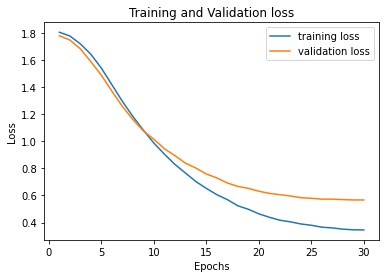

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, EPOCHS +1 )
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

## Performance Metrics
It's common to use precision, recall, and F1-score as the performance metrics.

In [ ]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(valid_pred, valid_df['label'].to_numpy(), target_names=label_names))

classifiation report
              precision    recall  f1-score   support

           0       0.70      0.80      0.75        61
           1       0.79      0.87      0.83        63
           2       0.77      0.82      0.79        66
           3       0.83      0.72      0.77        80
           4       0.80      0.73      0.76        77
           5       0.93      0.89      0.91        73

    accuracy                           0.80       420
   macro avg       0.80      0.81      0.80       420
weighted avg       0.81      0.80      0.80       420



## Error Analysis
With the predictions, we can plot the confusion matrix:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()

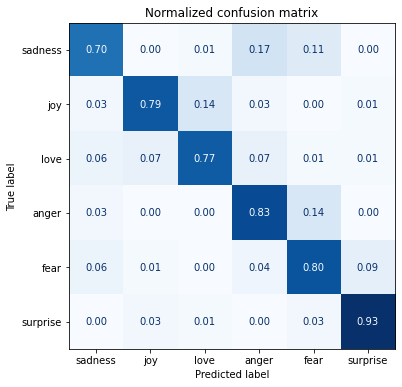

In [ ]:
plot_confusion_matrix(valid_pred,valid_df['label'].to_numpy(),labels=label_names)

You can see that **sadness** has a higher likelihood to be classified as **anger** or **fear**, leading to a lower f1 score.

<br>

## Prediction

*Now* let's use the trained model to predict the testing set.

In [ ]:
model.eval()
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

        loss = output.loss
        test_loss += loss.item()
   
        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [ ]:
print('classifiation report')
print(classification_report(test_pred, test_df['label'].to_numpy(),target_names=label_names))

classifiation report
              precision    recall  f1-score   support

           0       0.80      0.75      0.78        53
           1       0.82      0.82      0.82        50
           2       0.80      0.80      0.80        50
           3       0.80      0.80      0.80        50
           4       0.76      0.84      0.80        45
           5       0.92      0.88      0.90        52

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300



With the predictions, we can plot the confusion matrix again:

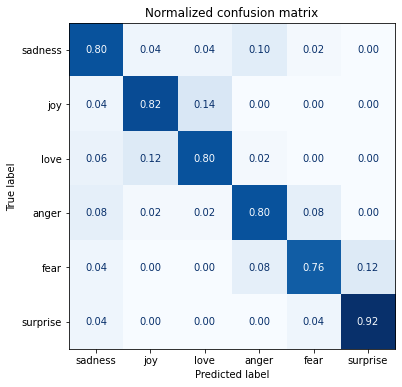

In [ ]:
plot_confusion_matrix(test_pred,test_df['label'].to_numpy(),labels=label_names)

Output the misclassified text:

In [ ]:
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

(55, 3)


,text,label,pred
6,i think im making up for feeling like i missed...,0,2
7,im not sure the feeling of loss will ever go a...,0,2
9,im afraid to call the guy from yesterday becau...,0,3
14,i feel like that im hated by most of the girls...,0,3
16,i wake up feeling like something terrifyingly ...,0,4
24,i had that kinda feeling but ignored it,0,3
26,i am again not inspired and after looking at i...,0,1
35,i do feel stressed,0,3
37,i feel much more energized than on a gloomy ra...,0,1
43,i cant feel dont turn your back on me i wont b...,0,3


In [ ]:
#hide
test_df.to_csv("test_results.csv",index= False)